In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
from sklearn import model_selection
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras import backend as K
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [63]:
data_train_pd = pd.read_csv('train.csv')

data_train = data_train_pd.values
print(data_train)
tmp = data_train[:,0]
print(tmp)

X = np.zeros([len(tmp),4])
print(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        X[i,j] = ord(tmp[i][j])-64

print(X)        


Y = data_train[:,1]
print(Y.shape)

[['DKWL' 0]
 ['FCHN' 0]
 ['KDQP' 0]
 ...
 ['SGHC' 0]
 ['KIGT' 0]
 ['PGPT' 0]]
['DKWL' 'FCHN' 'KDQP' ... 'SGHC' 'KIGT' 'PGPT']
(112000, 4)
[[ 4. 11. 23. 12.]
 [ 6.  3.  8. 14.]
 [11.  4. 17. 16.]
 ...
 [19.  7.  8.  3.]
 [11.  9.  7. 20.]
 [16.  7. 16. 20.]]
(112000,)


In [64]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [65]:
#np.random.seed(123)  # for reproducibility
val_percent = 0.10

print(X.shape[0])
values = list(range(X.shape[0]))

# np.random.shuffle(values)
training_ind, val_ind = sklearn.model_selection.train_test_split(values, train_size=1-val_percent, test_size=val_percent)
print(len(val_ind))
print(len(training_ind))

x_val = X[val_ind,:]
x_train = X[training_ind,:]


y_val = Y[val_ind]
y_train = Y[training_ind]
print(x_train.shape)
print(y_train.shape)
print(y_val.shape)


112000
11200
100800
(100800, 4)
(100800,)
(11200,)


In [66]:
custom_weight = sum(y_train)/len(y_train)
print(custom_weight)


from sklearn.utils import class_weight

def weighted_bce(y_true, y_pred):
    weights = (y_true * 30) + 1.
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce


0.037896825396825394


In [67]:
# # prediction at the end
# element = 0
# prova = data[element,:,:]
# prova_label_pred = np.zeros(15)

weights = np.copy(y_train)
weights[y_train == 1] = 1/custom_weight
weights[y_train == 0] = 1
print(weights.shape)

(100800,)


In [68]:
batch_size = 50
epochs = 2

# Neural network
# Define ANN architecture

ANN = Sequential()
ANN.name = "ANN"

ANN.add(Dense(32, input_shape=(4,), activation='relu'))
ANN.add(Dense(100, activation='relu')) 
# ANN.add(Dense(100, activation='relu'))
# ANN.add(Dense(100, activation='relu'))
# ANN.add(Dense(100, activation='relu'))
# ANN.add(Dense(100, activation='relu'))
# ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
ANN.add(Dropout(0.1))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
#     ANN.add(Dense(100, activation='relu'))
ANN.add(Dense(100, activation='relu'))
ANN.add(Dense(1, activation='sigmoid'))


#     class_custom_weight = class_weight.compute_class_weight('balanced', np.unique(y_train[:,i]), y_train[:,i])
#     class_custom_weight = [1, 1000]
# class_custom_weight = {0: 1, 1: (1-custom_weight[i])/custom_weight[i]}
# print(class_custom_weight)

ANN.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', precision_m, recall_m, f1_m])

weights = np.copy(y_train)
weights[y_train == 1] = 1/custom_weight
weights[y_train == 0] = 1
        
history = ANN.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    sample_weight = weights,
#                         shuffle=True,
#                         class_weight = class_custom_weight,
                    verbose=1,
                    validation_data=(x_val, y_val))

ANN.summary() 
score = ANN.evaluate(x_val, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test F1:', score[4])

# y_predict[:,i] = np.squeeze(ANN.predict(x_val))
# prova_label_pred[i] = ANN.predict(prova.reshape(1,12,70))

Train on 100800 samples, validate on 11200 samples
Epoch 1/2
100800/100800 [==============================] - 10s 104us/step - loss: 1.1598 - accuracy: 0.6514 - precision_m: 0.0766 - recall_m: 0.6057 - f1_m: 0.1300 - val_loss: 0.7249 - val_accuracy: 0.4613 - val_precision_m: 0.0554 - val_recall_m: 0.7202 - val_f1_m: 0.1008
Epoch 2/2
100800/100800 [==============================] - 10s 102us/step - loss: 1.1051 - accuracy: 0.6127 - precision_m: 0.0740 - recall_m: 0.6768 - f1_m: 0.1298 - val_loss: 0.5532 - val_accuracy: 0.6182 - val_precision_m: 0.0701 - val_recall_m: 0.6542 - val_f1_m: 0.1230
Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_30 (Dense)             (None, 100)               3300      
__________________________________________________________

dict_keys(['val_loss', 'val_accuracy', 'val_precision_m', 'val_recall_m', 'val_f1_m', 'loss', 'accuracy', 'precision_m', 'recall_m', 'f1_m'])


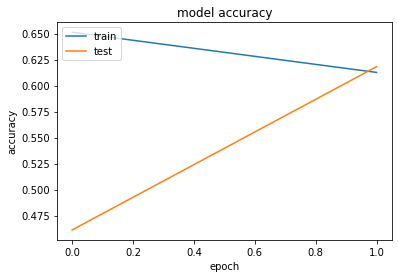

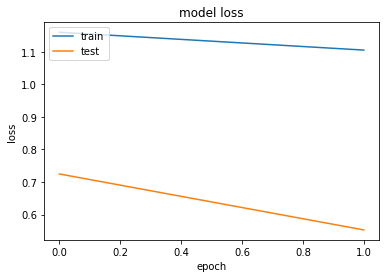

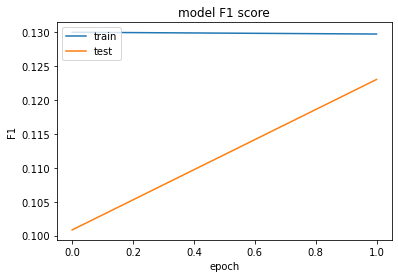

In [69]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F1 score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
y_pred = ANN.predict(x_val).reshape(len(val_ind),1)
print((y_pred.shape))
print((y_val.shape))
a =y_val.reshape(len(val_ind),1)
print(np.squeeze(y_pred).shape)


fpr, tpr, thresholds = roc_curve(np.squeeze(y_val), np.squeeze(y_pred))
auc = sklearn.metrics.auc(fpr, tpr)
roc_auc_score(y_val,y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f}) output = {}'.format(auc,i))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(auc)    

(11200, 1)
(11200,)
(11200,)


ValueError: unknown format is not supported